# Milestone 4 — Unsupervised + Clustering

**Pipelines included:**
- PCA -> KMeans
- TruncatedSVD -> KMeans
- NMF -> KMeans (nonnegative features via MinMax scaling)
- PCA -> Gaussian Mixture Model (GMM)
- TruncatedSVD -> Gaussian Mixture Model (GMM)
- PCA -> Agglomerative (linkage = ward/complete/average)

## Imports

In [1]:

import os, math, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Dict, Any, Tuple, Optional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    classification_report, confusion_matrix, accuracy_score, f1_score,
    precision_score, recall_score
)

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (7,5)

def evaluate_internal_metrics(X_emb: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    if len(np.unique(labels)) < 2:
        return {"silhouette": -1.0, "calinski_harabasz": 0.0, "davies_bouldin": np.inf}
    return {
        "silhouette": float(silhouette_score(X_emb, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(X_emb, labels)),
        "davies_bouldin": float(davies_bouldin_score(X_emb, labels)),
    }

def better(a: Dict[str, float], b: Optional[Dict[str, float]]) -> bool:
    if b is None: return True
    if a["silhouette"] > b["silhouette"]: return True
    if math.isclose(a["silhouette"], b["silhouette"], rel_tol=1e-6):
        if a["calinski_harabasz"] > b["calinski_harabasz"]:
            return True
        if math.isclose(a["calinski_harabasz"], b["calinski_harabasz"], rel_tol=1e-6):
            return a["davies_bouldin"] < b["davies_bouldin"]
    return False

def scatter2d(X2: np.ndarray, labels: np.ndarray, title: str):
    plt.figure()
    plt.scatter(X2[:,0], X2[:,1], c=labels, s=12)
    plt.title(title)
    plt.xlabel("PC/SVD/NMF-1")
    plt.ylabel("PC/SVD/NMF-2")
    plt.show()

def cluster_conditional_predict(y_true: np.ndarray, labels_train: np.ndarray, labels_test: np.ndarray, threshold: float=0.5):
    stats = pd.DataFrame({"c": labels_train, "y": y_true}).groupby("c")["y"].agg(["size","sum"]).reset_index()
    stats["pos_rate"] = stats["sum"] / stats["size"].clip(lower=1)
    rate_map = dict(zip(stats["c"], stats["pos_rate"]))
    y_pred = np.array([1 if rate_map.get(c, 0.0) >= threshold else 0 for c in labels_test], dtype=int)
    return stats.rename(columns={"c":"cluster"}), y_pred

def print_supervised_report(y_test: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)
    print(classification_report(y_test, y_pred, digits=4))
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "cm": cm.tolist()
    }

## Data Loading

In [2]:
DATA_PATH = '../data/raw/games_2016-2024_Milestone3.csv'
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)

target_col = 'home_win'
print("Guessed target column:", target_col)

df.head()

Loaded: (19436, 29)
Guessed target column: home_win


,season,date,home_team,away_team,home_runs,away_runs,home_win,run_diff,month,weekday,...,home_season_runs,home_ERA,home_WHIP,away_BA,away_OBP,away_SLG,away_OPS,away_season_runs,away_ERA,away_WHIP
0,2016,2016-04-03,TBR,TOR,3.0,5.0,0,-2.0,4,Sunday,...,672,4.20,1.32,0.248,0.330,0.426,0.755,759.0,3.79,1.23
1,2016,2016-04-03,PIT,STL,4.0,1.0,1,3.0,4,Sunday,...,729,4.22,1.40,0.255,0.325,0.443,0.768,779.0,4.08,1.32
2,2016,2016-04-03,KCR,NYM,4.0,3.0,1,1.0,4,Sunday,...,675,4.21,1.35,0.246,0.316,0.417,0.733,671.0,3.58,1.27
3,2016,2016-04-04,ARI,COL,5.0,10.0,0,-5.0,4,Monday,...,752,5.09,1.49,0.275,0.336,0.457,0.794,845.0,4.92,1.45
4,2016,2016-04-04,TEX,SEA,3.0,2.0,1,1.0,4,Monday,...,765,4.38,1.37,0.259,0.326,0.430,0.756,768.0,4.00,1.28


## Preprocessing and Feature Engineering

- Drop obvious outcome leakers (scores, final runs).
- Numeric: cast to float32, standardize.
- Categorical: OHE for low-cardinality columns.
- Drop ultra high-cardinality IDs/names from modeling inputs.
- Add simple **delta/ratio** home vs away stats if available.

In [3]:
leakers = [c for c in ['home_runs','away_runs','run_diff','home_score','away_score'] if c in df.columns]
df = df.drop(columns=leakers, errors='ignore')

for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('float32')

def _safe_div(a, b):
    r = a / b
    r.replace([np.inf, -np.inf], np.nan, inplace=True)
    r.fillna(0, inplace=True) 
    return r

for sfx in ['OPS','ERA','WHIP','BA']:
    h, a = f'home_{sfx}', f'away_{sfx}'
    if h in df.columns and a in df.columns:
        df[f'delta_{sfx.lower()}'] = df[h] - df[a]
        df[f'ratio_{sfx.lower()}'] = _safe_div(df[h], df[a])

if target_col and target_col in df.columns:
    y = df[target_col].astype('int32').values
    X = df.drop(columns=[target_col])
else:
    y = None
    X = df

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if (not pd.api.types.is_numeric_dtype(X[c])) and (X[c].nunique() < 40)]
hi_card = [c for c in X.columns if (not pd.api.types.is_numeric_dtype(X[c])) and (X[c].nunique() >= 40)]
X = X.drop(columns=hi_card, errors='ignore')
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if (not pd.api.types.is_numeric_dtype(X[c])) and (X[c].nunique() < 40)]

print(f"Numeric: {len(num_cols)} | Categorical (<=40 unique): {len(cat_cols)} | Dropped high-card: {len(hi_card)}")

if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
else:
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    y_train = y_test = None

numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])    

categorical = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])


pre = ColumnTransformer([
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols),
], remainder="drop", sparse_threshold=0.0)

Xtr = pre.fit_transform(X_train)
Xte = pre.transform(X_test)
print("Xtr:", Xtr.shape, "| Xte:", Xte.shape)

Numeric: 26 | Categorical (<=40 unique): 6 | Dropped high-card: 1
Xtr: (15548, 100) | Xte: (3888, 100)


## Hyperparameter Grids

In [4]:

PCA_COMPONENTS = [2, 3, 5, 8, 12]
SVD_COMPONENTS = [2, 3, 5, 8, 12]
NMF_COMPONENTS = [2, 3, 5, 8]

KMEANS_K = [2, 3, 4, 5, 6, 8, 10]
GMM_K = [2, 3, 4, 5, 6, 8, 10]
GMM_COV = ["full", "tied", "diag", "spherical"]

AGGLO_K = [2, 3, 4, 5, 6, 8, 10]
AGGLO_LINK = ["ward", "complete", "average"]

## Model Search

In [5]:
def search_pca_kmeans(Xtr, Xte):
    best = None; best_payload = None; records = []
    for nc in PCA_COMPONENTS:
        pca = PCA(n_components=nc, random_state=42)
        Ztr = pca.fit_transform(Xtr); Zte = pca.transform(Xte)
        for k in KMEANS_K:
            km = KMeans(n_clusters=k, random_state=42, n_init='auto')
            lab_tr = km.fit_predict(Ztr)
            lab_te = km.predict(Zte)
            met_tr = evaluate_internal_metrics(Ztr, lab_tr)
            met_te = evaluate_internal_metrics(Zte, lab_te)
            records.append({"model":"PCA+KMeans","n_components":nc,"k":k, **{f"tr_{k}":v for k,v in met_tr.items()}, **{f"te_{k}":v for k,v in met_te.items()}})
            if better(met_tr, best):
                best = met_tr
                best_payload = ("PCA+KMeans", {"n_components":nc,"k":k}, (pca, km, Ztr, Zte, lab_tr, lab_te, met_tr, met_te))
    return pd.DataFrame(records), best_payload

def search_svd_kmeans(Xtr, Xte):
    best = None; best_payload = None; records = []
    for nc in SVD_COMPONENTS:
        svd = TruncatedSVD(n_components=nc, random_state=42)
        Ztr = svd.fit_transform(Xtr); Zte = svd.transform(Xte)
        for k in KMEANS_K:
            km = KMeans(n_clusters=k, random_state=42, n_init='auto')
            lab_tr = km.fit_predict(Ztr)
            lab_te = km.predict(Zte)
            met_tr = evaluate_internal_metrics(Ztr, lab_tr)
            met_te = evaluate_internal_metrics(Zte, lab_te)
            records.append({"model":"SVD+KMeans","n_components":nc,"k":k, **{f"tr_{k}":v for k,v in met_tr.items()}, **{f"te_{k}":v for k,v in met_te.items()}})
            if better(met_tr, best):
                best = met_tr
                best_payload = ("SVD+KMeans", {"n_components":nc,"k":k}, (svd, km, Ztr, Zte, lab_tr, lab_te, met_tr, met_te))
    return pd.DataFrame(records), best_payload

def search_nmf_kmeans(Xtr, Xte):
    mm = MinMaxScaler()
    Xtr_nn = mm.fit_transform(Xtr)
    Xte_nn = mm.transform(Xte)
    Xte_nn_clipped = np.maximum(Xte_nn, 0)
    best = None; best_payload = None; records = []
    for nc in NMF_COMPONENTS:
        if nc >= Xtr_nn.shape[1]: 
            continue
        nmf = NMF(n_components=nc, random_state=42, init='nndsvda', max_iter=600)
        Ztr = nmf.fit_transform(Xtr_nn)
        Zte = nmf.transform(Xte_nn_clipped)
        for k in KMEANS_K:
            km = KMeans(n_clusters=k, random_state=42, n_init='auto')
            lab_tr = km.fit_predict(Ztr)
            lab_te = km.predict(Zte)
            met_tr = evaluate_internal_metrics(Ztr, lab_tr)
            met_te = evaluate_internal_metrics(Zte, lab_te)
            records.append({"model":"NMF+KMeans","n_components":nc,"k":k, **{f"tr_{k}":v for k,v in met_tr.items()}, **{f"te_{k}":v for k,v in met_te.items()}})
            if better(met_tr, best):
                best = met_tr
                best_payload = ("NMF+KMeans", {"n_components":nc,"k":k}, (nmf, km, Ztr, Zte, lab_tr, lab_te, met_tr, met_te, mm))
    return pd.DataFrame(records), best_payload

def search_pca_gmm(Xtr, Xte):
    best = None; best_payload = None; records = []
    for nc in PCA_COMPONENTS:
        pca = PCA(n_components=nc, random_state=42)
        Ztr = pca.fit_transform(Xtr); Zte = pca.transform(Xte)
        for k in GMM_K:
            for cov in GMM_COV:
                gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
                gmm.fit(Ztr)
                lab_tr = gmm.predict(Ztr)
                lab_te = gmm.predict(Zte)
                met_tr = evaluate_internal_metrics(Ztr, lab_tr)
                met_te = evaluate_internal_metrics(Zte, lab_te)
                records.append({"model":"PCA+GMM","n_components":nc,"k":k,"cov":cov, **{f"tr_{k}":v for k,v in met_tr.items()}, **{f"te_{k}":v for k,v in met_te.items()}})
                if better(met_tr, best):
                    best = met_tr
                    best_payload = ("PCA+GMM", {"n_components":nc,"k":k,"covariance_type":cov}, (pca, gmm, Ztr, Zte, lab_tr, lab_te, met_tr, met_te))
    return pd.DataFrame(records), best_payload

def search_svd_gmm(Xtr, Xte):
    best = None; best_payload = None; records = []
    for nc in SVD_COMPONENTS:
        svd = TruncatedSVD(n_components=nc, random_state=42)
        Ztr = svd.fit_transform(Xtr); Zte = svd.transform(Xte)
        for k in GMM_K:
            for cov in GMM_COV:
                gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
                gmm.fit(Ztr)
                lab_tr = gmm.predict(Ztr)
                lab_te = gmm.predict(Zte)
                met_tr = evaluate_internal_metrics(Ztr, lab_tr)
                met_te = evaluate_internal_metrics(Zte, lab_te)
                records.append({"model":"SVD+GMM","n_components":nc,"k":k,"cov":cov, **{f"tr_{k}":v for k,v in met_tr.items()}, **{f"te_{k}":v for k,v in met_te.items()}})
                if better(met_tr, best):
                    best = met_tr
                    best_payload = ("SVD+GMM", {"n_components":nc,"k":k,"covariance_type":cov}, (svd, gmm, Ztr, Zte, lab_tr, lab_te, met_tr, met_te))
    return pd.DataFrame(records), best_payload

def search_pca_agglomerative(Xtr, Xte):
    best = None; best_payload = None; records = []
    for nc in PCA_COMPONENTS:
        pca = PCA(n_components=nc, random_state=42)
        Ztr = pca.fit_transform(Xtr); Zte = pca.transform(Xte)
        for k in AGGLO_K:
            for link in AGGLO_LINK:
                if link == "ward":
                    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
                else:
                    agg = AgglomerativeClustering(n_clusters=k, linkage=link)
                lab_tr = agg.fit_predict(Ztr)
                centroids = np.vstack([Ztr[lab_tr==j].mean(axis=0) for j in range(k)])
                d2 = ((Zte[:,None,:] - centroids[None,:,:])**2).sum(axis=2)
                lab_te = d2.argmin(axis=1)
                met_tr = evaluate_internal_metrics(Ztr, lab_tr)
                met_te = evaluate_internal_metrics(Zte, lab_te)
                records.append({"model":"PCA+Agglomerative","n_components":nc,"k":k,"linkage":link, **{f"tr_{k}":v for k,v in met_tr.items()}, **{f"te_{k}":v for k,v in met_te.items()}})
                if better(met_tr, best):
                    best = met_tr
                    best_payload = ("PCA+Agglomerative", {"n_components":nc,"k":k,"linkage":link}, (pca, agg, Ztr, Zte, lab_tr, lab_te, met_tr, met_te))
    return pd.DataFrame(records), best_payload

## Run All Searches

In [ ]:
out_dir = Path("outputs2")
out_dir.mkdir(parents=True, exist_ok=True)

search_outputs = {}
comparison_rows = []

models = [
    ("PCA+KMeans", search_pca_kmeans),
    ("SVD+KMeans", search_svd_kmeans),
    ("NMF+KMeans", search_nmf_kmeans),
    ("PCA+GMM",    search_pca_gmm),
    ("SVD+GMM",    search_svd_gmm),
    ("PCA+Agglo",  search_pca_agglomerative),
]

for name, fn in models:
    print(f"\n=== Searching {name} ===")
    df_res, best_payload = fn(Xtr, Xte)
    search_outputs[name] = (df_res, best_payload)
    out_csv = f"outputs2/m4_search_{name.replace('+','_').replace(' ','_').lower()}.csv"
    df_res.to_csv(out_csv, index=False)
    print("Saved search table ->", out_csv)
    label, params, payload = best_payload
    _, _, _, _, _, _, met_tr, met_te = payload[:8]
    comparison_rows.append({
        "model": name,
        "params": json.dumps(params),
        "tr_silhouette": met_tr["silhouette"],
        "te_silhouette": met_te["silhouette"],
        "tr_calinski_harabasz": met_tr["calinski_harabasz"],
        "te_calinski_harabasz": met_te["calinski_harabasz"],
        "tr_davies_bouldin": met_tr["davies_bouldin"],
        "te_davies_bouldin": met_te["davies_bouldin"],
    })

comparison_df = pd.DataFrame(comparison_rows).sort_values(by=["te_silhouette","tr_silhouette"], ascending=[False, False]).reset_index(drop=True)
print(comparison_df.head(10))
comp_path = "outputs2/m4_model_comparison.csv"
comparison_df.to_csv(comp_path, index=False)
print("Saved comparison table ->", comp_path)


=== Searching PCA+KMeans ===
Saved search table -> outputs2/m4_search_pca_kmeans.csv

=== Searching SVD+KMeans ===
Saved search table -> outputs2/m4_search_svd_kmeans.csv

=== Searching NMF+KMeans ===
Saved search table -> outputs2/m4_search_nmf_kmeans.csv

=== Searching PCA+GMM ===
Saved search table -> outputs2/m4_search_pca_gmm.csv

=== Searching SVD+GMM ===


## Best Config and Supervised Summary


--- PCA+KMeans best config ---
Params: {'n_components': 2, 'k': 2}


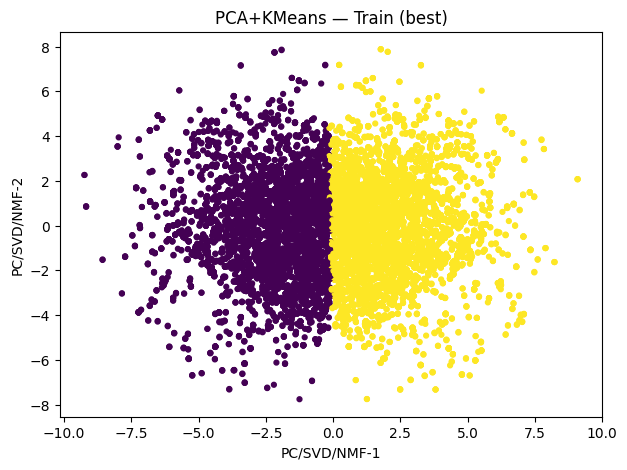

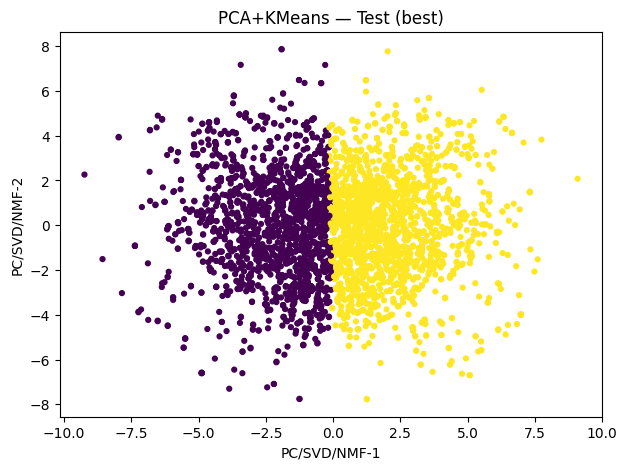

Train cluster positive rates:
   cluster  size   sum  pos_rate
0        0  7465  3290  0.440723
1        1  8083  4952  0.612644

Test supervised summary:
Confusion matrix [[TN, FP],[FN, TP]]:
 [[1041  786]
 [ 864 1197]]
              precision    recall  f1-score   support

           0     0.5465    0.5698    0.5579      1827
           1     0.6036    0.5808    0.5920      2061

    accuracy                         0.5756      3888
   macro avg     0.5750    0.5753    0.5749      3888
weighted avg     0.5768    0.5756    0.5760      3888

Saved predictions -> outputs2/m4_test_predictions_pca_kmeans.csv

--- SVD+KMeans best config ---
Params: {'n_components': 2, 'k': 2}


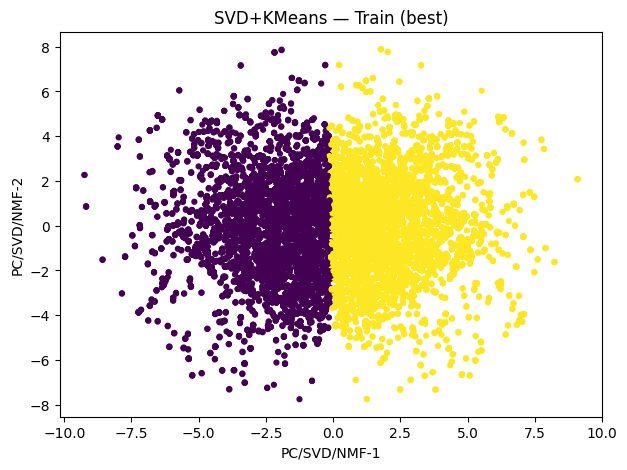

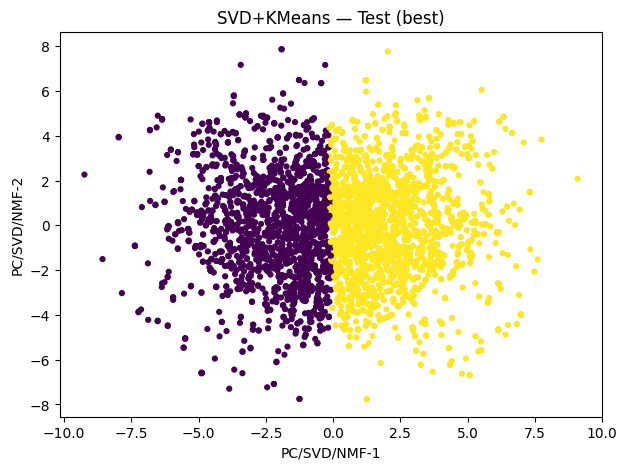

Train cluster positive rates:
   cluster  size   sum  pos_rate
0        0  7465  3290  0.440723
1        1  8083  4952  0.612644

Test supervised summary:
Confusion matrix [[TN, FP],[FN, TP]]:
 [[1041  786]
 [ 864 1197]]
              precision    recall  f1-score   support

           0     0.5465    0.5698    0.5579      1827
           1     0.6036    0.5808    0.5920      2061

    accuracy                         0.5756      3888
   macro avg     0.5750    0.5753    0.5749      3888
weighted avg     0.5768    0.5756    0.5760      3888

Saved predictions -> outputs2/m4_test_predictions_svd_kmeans.csv

--- NMF+KMeans best config ---
Params: {'n_components': 2, 'k': 3}


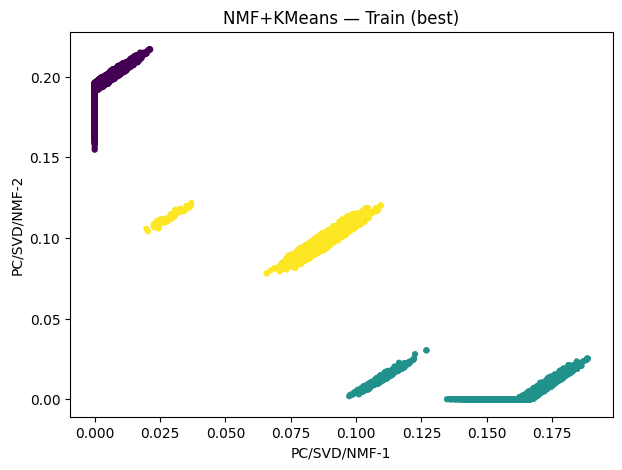

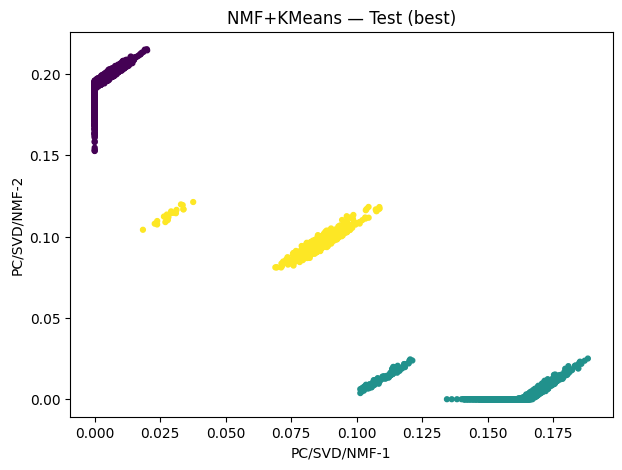

Train cluster positive rates:
   cluster  size   sum  pos_rate
0        0  6471  3440  0.531603
1        1  6522  3505  0.537412
2        2  2555  1297  0.507632

Test supervised summary:
Confusion matrix [[TN, FP],[FN, TP]]:
 [[   0 1827]
 [   0 2061]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1827
           1     0.5301    1.0000    0.6929      2061

    accuracy                         0.5301      3888
   macro avg     0.2650    0.5000    0.3464      3888
weighted avg     0.2810    0.5301    0.3673      3888

Saved predictions -> outputs2/m4_test_predictions_nmf_kmeans.csv

--- PCA+GMM best config ---
Params: {'n_components': 5, 'k': 2, 'covariance_type': 'full'}


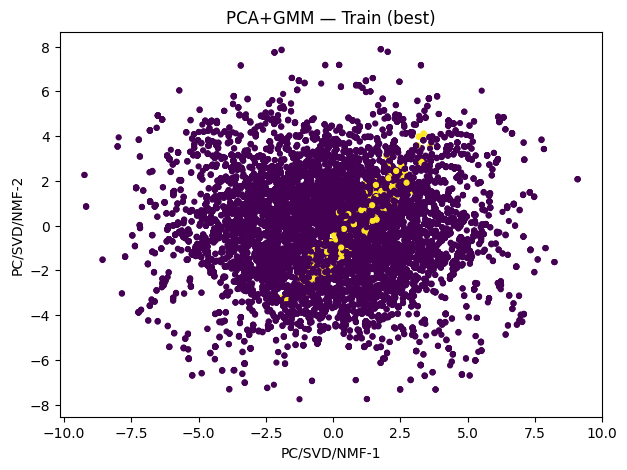

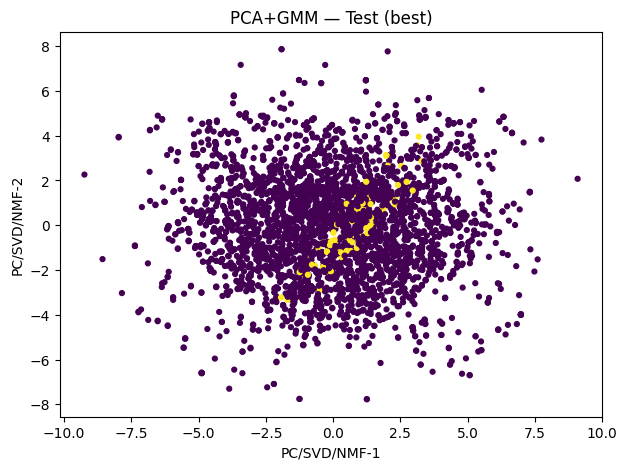

Train cluster positive rates:
   cluster   size   sum  pos_rate
0        0  15029  7957  0.529443
1        1    519   285  0.549133

Test supervised summary:
Confusion matrix [[TN, FP],[FN, TP]]:
 [[   0 1827]
 [   0 2061]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1827
           1     0.5301    1.0000    0.6929      2061

    accuracy                         0.5301      3888
   macro avg     0.2650    0.5000    0.3464      3888
weighted avg     0.2810    0.5301    0.3673      3888

Saved predictions -> outputs2/m4_test_predictions_pca_gmm.csv

--- SVD+GMM best config ---
Params: {'n_components': 5, 'k': 2, 'covariance_type': 'full'}


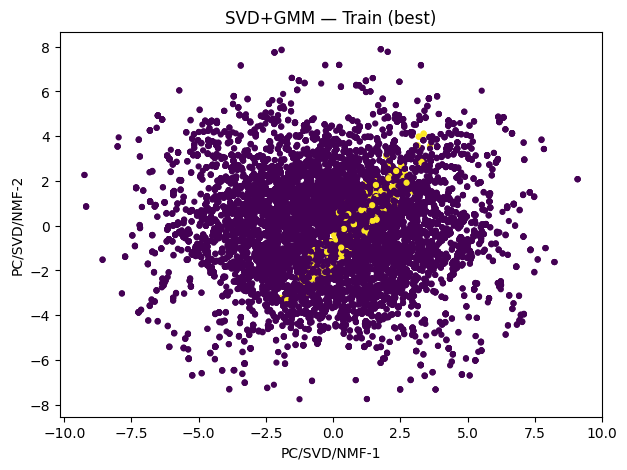

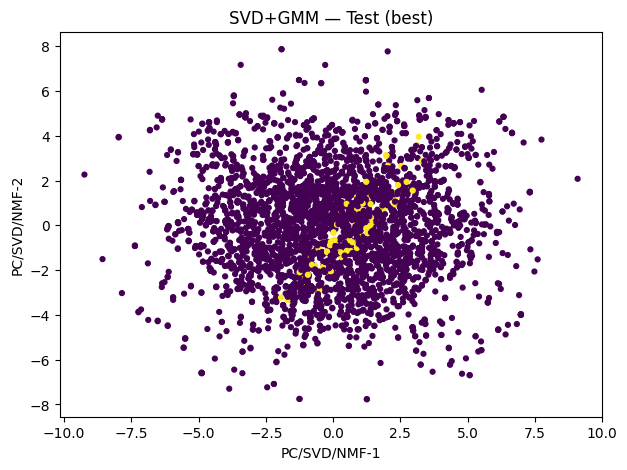

Train cluster positive rates:
   cluster   size   sum  pos_rate
0        0  15029  7957  0.529443
1        1    519   285  0.549133

Test supervised summary:
Confusion matrix [[TN, FP],[FN, TP]]:
 [[   0 1827]
 [   0 2061]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1827
           1     0.5301    1.0000    0.6929      2061

    accuracy                         0.5301      3888
   macro avg     0.2650    0.5000    0.3464      3888
weighted avg     0.2810    0.5301    0.3673      3888

Saved predictions -> outputs2/m4_test_predictions_svd_gmm.csv

--- PCA+Agglo best config ---
Params: {'n_components': 5, 'k': 2, 'linkage': 'average'}


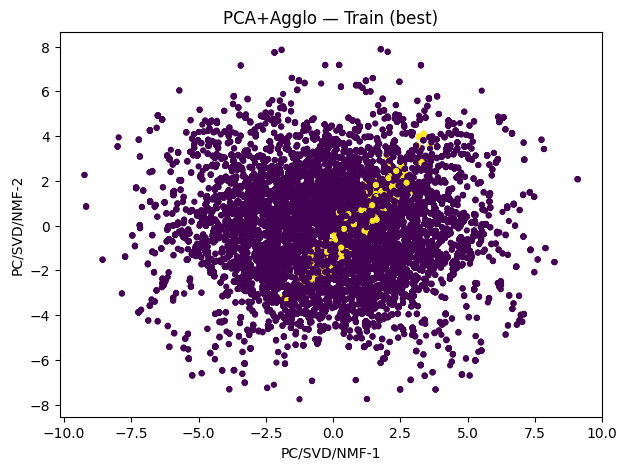

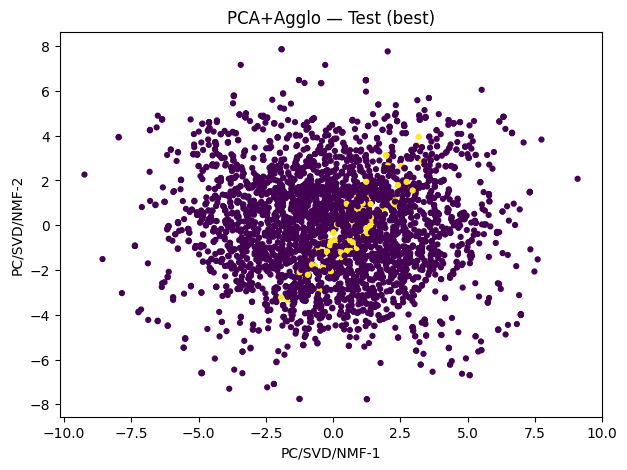

Train cluster positive rates:
   cluster   size   sum  pos_rate
0        0  15029  7957  0.529443
1        1    519   285  0.549133

Test supervised summary:
Confusion matrix [[TN, FP],[FN, TP]]:
 [[   0 1827]
 [   0 2061]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1827
           1     0.5301    1.0000    0.6929      2061

    accuracy                         0.5301      3888
   macro avg     0.2650    0.5000    0.3464      3888
weighted avg     0.2810    0.5301    0.3673      3888

Saved predictions -> outputs2/m4_test_predictions_pca_agglo.csv
        model                                             params  \
0  NMF+KMeans                        {"n_components": 2, "k": 3}   
1     PCA+GMM  {"n_components": 5, "k": 2, "covariance_type":...   
2     SVD+GMM  {"n_components": 5, "k": 2, "covariance_type":...   
3   PCA+Agglo  {"n_components": 5, "k": 2, "linkage": "average"}   
4  PCA+KMeans                        {"n_comp

In [ ]:
pred_summaries = []
for name, (df_res, best_payload) in search_outputs.items():
    label, params, payload = best_payload
    objs = payload

    print(f"\n--- {name} best config ---")
    print("Params:", params)

    if name in ["PCA+KMeans","SVD+KMeans","PCA+GMM","SVD+GMM","PCA+Agglo","NMF+KMeans"]:
        if name == "NMF+KMeans":
            reducer, clusterer, Ztr, Zte, lab_tr, lab_te, met_tr, met_te, mm = objs
        else:
            reducer, clusterer, Ztr, Zte, lab_tr, lab_te, met_tr, met_te = objs[:8]

        if Ztr.shape[1] >= 2:
            scatter2d(Ztr[:, :2], lab_tr, f"{name} — Train (best)")
            scatter2d(Zte[:, :2], lab_te, f"{name} — Test (best)")

        if y_train is not None:
            stats, y_pred = cluster_conditional_predict(y_train, lab_tr, lab_te, threshold=0.5)
            print("Train cluster positive rates:")
            print(stats)
            print("\nTest supervised summary:")
            sup = print_supervised_report(y_test, y_pred)

            df_out = X_test.copy().reset_index(drop=True)
            df_out["y_true"] = y_test
            df_out["cluster"] = lab_te
            df_out["cluster_train_pos_rate"] = df_out["cluster"].map(dict(zip(stats["cluster"], stats["pos_rate"])))
            df_out["y_pred"] = y_pred
            df_out["correct"] = (df_out["y_true"] == df_out["y_pred"]).astype(int)
            df_out["error_type"] = np.where(
                df_out["correct"]==1,
                np.where(df_out["y_true"]==1, "TP", "TN"),
                np.where(df_out["y_pred"]==1, "FP", "FN")
            )
            out_csv = f"outputs2/m4_test_predictions_{name.replace('+','_').replace(' ','_').lower()}.csv"
            df_out.to_csv(out_csv, index=False)
            print("Saved predictions ->", out_csv)

            pred_summaries.append({
                "model": name,
                "params": json.dumps(params),
                "test_accuracy": sup["accuracy"],
                "test_f1": sup["f1"],
                "test_precision": sup["precision"],
                "test_recall": sup["recall"]
            })

if pred_summaries:
    pred_df = pd.DataFrame(pred_summaries).sort_values(by=["test_f1","test_accuracy"], ascending=[False, False]).reset_index(drop=True)
    print(pred_df)
    pred_path = "outputs2/m4_supervised_cluster_predictor_scores.csv"
    pred_df.to_csv(pred_path, index=False)
    print("Saved supervised predictor summary ->", pred_path)
else:
    print("No binary outcome found; skipped supervised summaries.")


## Fitting Graph Position & Next Models

In [ ]:
def interpret_train_test_sil(train_sil: float, test_sil: float) -> str:
    if train_sil - test_sil > 0.05:
        return "Likely overfitting: train >> test silhouette."
    if test_sil > train_sil:
        return "Encouraging: test >= train silhouette."
    return "Stable: train and test silhouettes are similar."

summary_rows = []
for _, row in comparison_df.iterrows():
    msg = interpret_train_test_sil(row["tr_silhouette"], row["te_silhouette"])
    summary_rows.append({
        "model": row["model"],
        "params": row["params"],
        "train_silhouette": row["tr_silhouette"],
        "test_silhouette": row["te_silhouette"],
        "interpretation": msg
    })
summary_df = pd.DataFrame(summary_rows)
display(summary_df.head(10))
sum_path = "outputs2/m4_fit_position_summary.csv"
summary_df.to_csv(sum_path, index=False)
print("Saved:", sum_path)

print("\nSuggested next models and tuning ideas:")
print("- Try Spectral Clustering on the best embedding (PCA/SVD) for non-convex clusters.")
print("- For GMM, compare AIC/BIC across k and covariance types; consider Dirichlet Process GMM for adaptive k.")
print("- For Agglomerative, inspect a dendrogram offline to choose k and linkage.")
print("- Engineer richer features (rolling form, park factors, platoon splits) to reveal stronger structure.")

,model,params,train_silhouette,test_silhouette,interpretation
0,NMF+KMeans,"{""n_components"": 2, ""k"": 3}",0.878460,0.879050,Encouraging: test >= train silhouette.
1,PCA+GMM,"{""n_components"": 5, ""k"": 2, ""covariance_type"":...",0.496798,0.492847,Stable: train and test silhouettes are similar.
2,PCA+Agglo,"{""n_components"": 5, ""k"": 2, ""linkage"": ""average""}",0.496798,0.492847,Stable: train and test silhouettes are similar.
3,SVD+GMM,"{""n_components"": 5, ""k"": 2, ""covariance_type"":...",0.496233,0.492241,Stable: train and test silhouettes are similar.
4,SVD+KMeans,"{""n_components"": 2, ""k"": 2}",0.343111,0.336618,Stable: train and test silhouettes are similar.
5,PCA+KMeans,"{""n_components"": 2, ""k"": 2}",0.343110,0.336617,Stable: train and test silhouettes are similar.


Saved: outputs2/m4_fit_position_summary.csv

Suggested next models and tuning ideas:
- Try Spectral Clustering on the best embedding (PCA/SVD) for non-convex clusters.
- For GMM, compare AIC/BIC across k and covariance types; consider Dirichlet Process GMM for adaptive k.
- For Agglomerative, inspect a dendrogram offline to choose k and linkage.
- Engineer richer features (rolling form, park factors, platoon splits) to reveal stronger structure.


## Artifacts

In [ ]:
print("Artifacts written to outputs2:")
for f in sorted(os.listdir("outputs2")):
    print("-", f)

Artifacts written to outputs2:
- m4_fit_position_summary.csv
- m4_model_comparison.csv
- m4_search_nmf_kmeans.csv
- m4_search_pca_agglo.csv
- m4_search_pca_gmm.csv
- m4_search_pca_kmeans.csv
- m4_search_svd_gmm.csv
- m4_search_svd_kmeans.csv
- m4_supervised_cluster_predictor_scores.csv
- m4_test_predictions_nmf_kmeans.csv
- m4_test_predictions_pca_agglo.csv
- m4_test_predictions_pca_gmm.csv
- m4_test_predictions_pca_kmeans.csv
- m4_test_predictions_svd_gmm.csv
- m4_test_predictions_svd_kmeans.csv
